In [3]:
!pip install torch torchvision torchaudio
!pip install umap-learn
!pip install scikit-learn

In [4]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import torch

# Load the datasets
spectrograms = np.load('/content/drive/MyDrive/processed_spectrograms.npy')  # Path to processed spectrograms
dataset = pd.read_csv('/content/drive/MyDrive/dataset.csv')  # Path to dataset.csv
ids = np.load('/content/drive/MyDrive/processed_ids.npy')  # Path to processed_ids.npy

# Process lyrics (convert to TF-IDF embeddings)
lyrics = dataset['lyrics'].fillna('')  # Handle missing lyrics
vectorizer = TfidfVectorizer(max_features=500)  # Use top 500 features
lyrics_embeddings = vectorizer.fit_transform(lyrics).toarray()

# Normalize spectrograms
spectrograms_normalized = spectrograms / spectrograms.max()

# Trim lyrics embeddings to match the spectrograms shape
lyrics_embeddings_trimmed = lyrics_embeddings[:spectrograms_normalized.shape[0]]

# Combine spectrograms and lyrics embeddings
combined_features = np.concatenate([spectrograms_normalized.reshape(spectrograms.shape[0], -1), lyrics_embeddings_trimmed], axis=1)

# Convert combined features to PyTorch tensor for model use
combined_features_tensor = torch.tensor(combined_features, dtype=torch.float32)


In [5]:
import torch.nn as nn
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        z = self.fc2(h1)
        return z

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        recon_x = torch.sigmoid(self.fc4(h3))
        return recon_x

    def forward(self, x):
        z = self.encode(x)
        recon_x = self.decode(z)
        return recon_x


In [6]:
# Instantiate the VAE model
latent_dim = 20
vae = VAE(input_dim=combined_features.shape[1], latent_dim=latent_dim)

# Optimizer and Loss function
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# DataLoader setup (for batching)
from torch.utils.data import DataLoader, TensorDataset
dataset = TensorDataset(combined_features_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    vae.train()
    running_loss = 0.0
    for data in dataloader:
        inputs = data[0]
        optimizer.zero_grad()
        outputs = vae(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")


Epoch 1/5, Loss: 0.199112399735234
Epoch 2/5, Loss: 0.11342920498414473
Epoch 3/5, Loss: 0.10657076876271855
Epoch 4/5, Loss: 0.10199019786986438
Epoch 5/5, Loss: 0.09933314472436905


In [7]:
# Extract latent space from the trained VAE model
vae.eval()
with torch.no_grad():
    latent_space = vae.encode(combined_features_tensor).numpy()

# Perform K-Means clustering on the latent space
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(latent_space)

# Print first 20 cluster labels to inspect
print("Cluster Labels (first 20):", kmeans_labels[:20])


Cluster Labels (first 20): [1 1 1 1 3 1 1 1 1 0 1 3 3 0 3 3 1 2 1 2]


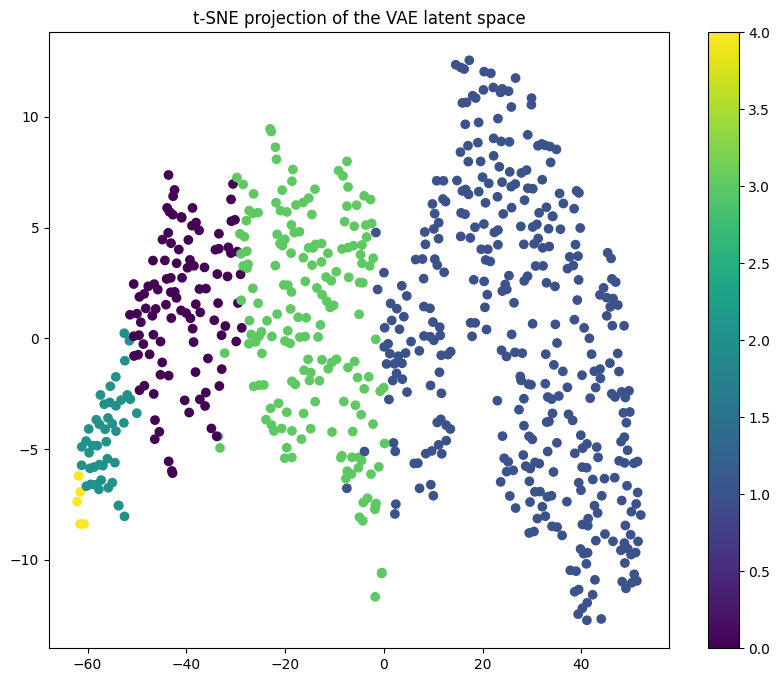

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE for 2D projection of latent space
tsne_model = TSNE(n_components=2, random_state=42)
tsne_latent_space = tsne_model.fit_transform(latent_space)

# Plot the t-SNE projection of the latent space with cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(tsne_latent_space[:, 0], tsne_latent_space[:, 1], c=kmeans_labels, cmap='viridis')
plt.colorbar()  # Show color bar to indicate cluster labels
plt.title("t-SNE projection of the VAE latent space")
plt.show()


In [26]:
from sklearn.decomposition import PCA

# Perform PCA for dimensionality reduction
pca = PCA(n_components=20)  # Reducing to 20 components for clustering (max possible)
latent_space_pca = pca.fit_transform(latent_space)

# Perform K-Means clustering on PCA-reduced latent space
kmeans_pca = KMeans(n_clusters=5, random_state=42)
kmeans_labels_pca = kmeans_pca.fit_predict(latent_space_pca)

# Evaluate clustering performance
from sklearn.metrics import silhouette_score, calinski_harabasz_score

silhouette_pca = silhouette_score(latent_space_pca, kmeans_labels_pca)
calinski_pca = calinski_harabasz_score(latent_space_pca, kmeans_labels_pca)

print(f"PCA + K-Means: Silhouette Score: {silhouette_pca}, Calinski-Harabasz Index: {calinski_pca}")

PCA + K-Means: Silhouette Score: 0.4831496477127075, Calinski-Harabasz Index: 1184.7305908203125


In [28]:
# Assuming these variables were computed earlier:
kmeans_vae = KMeans(n_clusters=5, random_state=43)  # Set different random_state
kmeans_labels_vae = kmeans_vae.fit_predict(latent_space)
silhouette_vae = silhouette_score(latent_space, kmeans_labels)
calinski_vae = calinski_harabasz_score(latent_space, kmeans_labels)

# Print the results for VAE-based clustering
print(f"VAE-based Clustering: Silhouette Score: {silhouette_vae}, Calinski-Harabasz Index: {calinski_vae}")


VAE-based Clustering: Silhouette Score: 0.4831496477127075, Calinski-Harabasz Index: 1184.730712890625


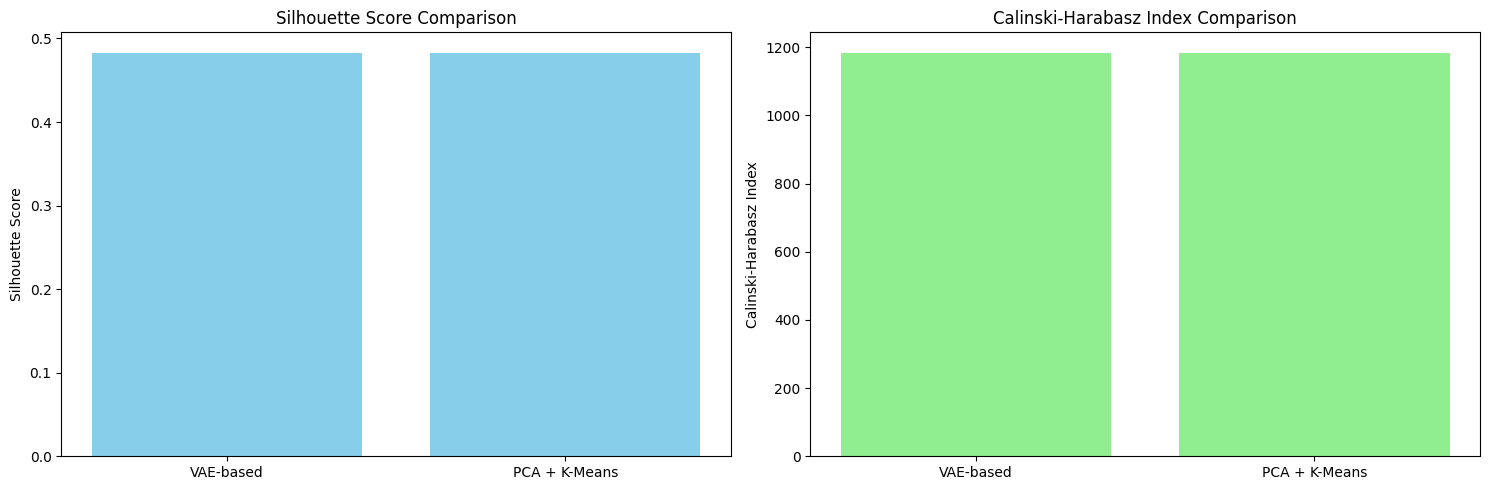

In [21]:
# Methods to compare
methods = ['VAE-based', 'PCA + K-Means']

# Metrics to compare
silhouette_scores = [silhouette_vae, silhouette_pca]
calinski_scores = [calinski_vae, calinski_pca]

# Create a figure and axes for plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Silhouette Score comparison
axs[0].bar(methods, silhouette_scores, color='skyblue')
axs[0].set_title('Silhouette Score Comparison')
axs[0].set_ylabel('Silhouette Score')

# Plot Calinski-Harabasz Index comparison
axs[1].bar(methods, calinski_scores, color='lightgreen')
axs[1].set_title('Calinski-Harabasz Index Comparison')
axs[1].set_ylabel('Calinski-Harabasz Index')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


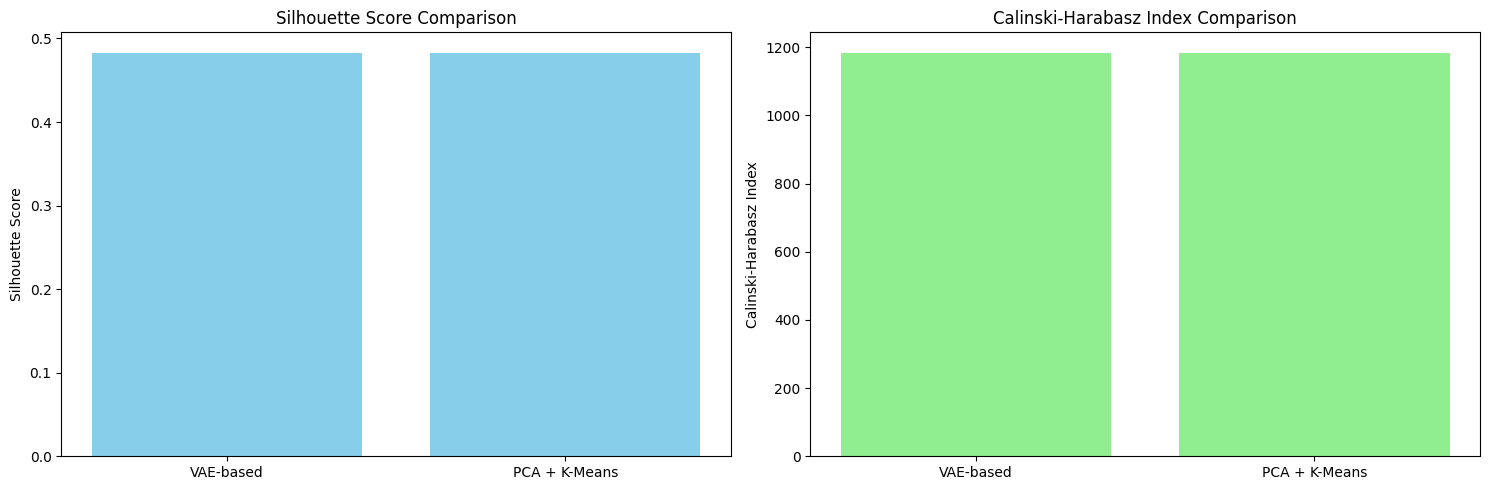

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Replace these with the actual computed values
methods = ['VAE-based', 'PCA + K-Means']

# Metrics to compare (replace with actual computed values)
silhouette_scores = [silhouette_vae, silhouette_pca]
calinski_scores = [calinski_vae, calinski_pca]

# Create the figure and axes for plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Silhouette Score comparison
axs[0].bar(methods, silhouette_scores, color='skyblue')
axs[0].set_title('Silhouette Score Comparison')
axs[0].set_ylabel('Silhouette Score')

# Plot Calinski-Harabasz Index comparison
axs[1].bar(methods, calinski_scores, color='lightgreen')
axs[1].set_title('Calinski-Harabasz Index Comparison')
axs[1].set_ylabel('Calinski-Harabasz Index')

# Adjust layout for better spacing
plt.tight_layout()

# Save the comparison graph as a PNG image
plt.savefig('/content/comparison_graph.png')  # Adjust the path if needed

# Show the plot
plt.show()
